# A first look at ApRES data

In previous pages in this chapter we have looked at the theory behind the operation of the autonomous phase-sensitive radio-echo sounder. We have seen how it is the frequency content of the signal recorded by ApRES which tells us the range to sub-surface reflectors, and how to use a fourier transform to estimate this frequency content and estimate the range to reflectors. 

On this page we will load ApRES collected on Thwaites Glacier as part of the International Thwaites Glacier Collaboration (ITGC), use the principle we discussed inthe previous page to examine the data in a simple way, and finally plot up a profile of power showing the range to many sub-surface (englacial) reflectors. 

## Load packages
As well as numpy and matplotlib, we will use a package called [xapres](https://github.com/ldeo-glaciology/xapres) which was developed to load and process data in python. xapres is built around xarray, a package for working with multi-dimensional arrays. 

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xapres as xa

## The data
The data we will use was collected on Thwaites Glacier (TG) by Elizabeth Case as part of the GHOST overland traverse in the 2022-2023 field season. FOllow up data was collected Alex Brisbourne and Sierra Melton in 2023-2024. Part of these ApRES surveys was a line of measurements taken along a profile approximately aligned with flow down the middle of TG. 

As described in previous pages, ApRES data is collected in 'chirps', each 1 second long. Generally, many chirps are recorded repeatedly at each location and together these are known as a burst. ApRES data is stored in a binary format with the file extension .dat. 

At each of ~250 waypoints, Elizabeth collected a burst consisting of 100 chirps. 

## Load the data
The cell below creates a `from_data` object from the xapres package, which will be used to load the data.

In [103]:
fd = xa.load.from_dats(max_range=2500)

The TG ApRES data is stored in an open google bucket. We can list and count the .dat files in the bucket as follows:

In [112]:
root_directory = 'gs://ldeo-glaciology/apres/thwaites/'
filenames = fd.list_files(directory = root_directory, remote_load=True)
len(filenames)

890

There are many hundreds of .dat files from different seasons and different locations. We will chose a .dat file at random to load (note that most of these data are arranged so that one .dat file are in each directory, but this is not always the case, so we specify `file_numbers_to_process=[0]` to ensure we only load one file). 

In [140]:
directory = os.path.dirname(filenames[20])
ds = fd.load_all(directory = directory, remote_load=True, file_numbers_to_process=[0])

This produced an xarray Dataset contained many variables. The only one we are interested in right now is `ds.chirp`, which is the voltage recorded by ApRES during each one-second chirp. This is the so-called deramped signal. It is the result of combininghte tranmsitted chirp with the received signal and filtering out the high frequnecy component of the result. This leaves a signal with a frequency content that indicates the range to the sub-surface reflectors. See the two previous pages for more details. 

In [143]:
chirp = ds.chirp.squeeze()    # remove the singleton dimensions
chirp

<xarray.DataArray 'chirp' (chirp_time: 40001, chirp_num: 100)>
array([[ 6.86645508e-04,  4.70352173e-02, -3.73840332e-03, ...,
         9.42230225e-03,  2.36892700e-02,  5.51605225e-02],
       [ 2.48718262e-02,  7.32421875e-02,  2.11334229e-02, ...,
         3.80325317e-02,  4.21524048e-02,  7.84301758e-02],
       [ 1.23443604e-01,  2.06375122e-01,  1.13945007e-01, ...,
         1.49841309e-01,  1.29928589e-01,  1.91040039e-01],
       ...,
       [ 5.45120239e-02,  4.97055054e-02,  4.74548340e-02, ...,
         4.46319580e-02,  5.30624390e-02,  5.40542603e-02],
       [ 8.31985474e-02,  8.68606567e-02,  6.67953491e-02, ...,
         7.78198242e-02,  8.02993774e-02,  7.90023804e-02],
       [ 9.29603577e-01,  9.34638977e-01,  9.12284851e-01, ...,
         9.14497375e-01,  9.12971497e-01,  9.11254883e-01]])
Coordinates:
    time          datetime64[ns] 2022-12-31T09:18:13
  * chirp_time    (chirp_time) float64 0.0 2.5e-05 5e-05 7.5e-05 ... 1.0 1.0 1.0
  * chirp_num     (chirp_num) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
    filename      <U86 'ldeo-glaciology/apres/thwaites/2022-2023/Point/G1-25-...
    burst_number  int64 0
    AFGain        int64 -4
    attenuator    float64 26.0
    orientation   <U7 'unknown'
Attributes:
    long_name:    de-ramped chirp
    units:        volts
    description:  voltage from the analog-to-digital converter after the rece...

This is one burst of data, recorded on New Year's eve 2022. It is a real-valued array with  two dimensions: chirp_time and chirp_num. Chirp_time is the time through each chirp. As each chirp is one second long, the sample frequency is 40,001 Hz. Chirp_num is the chirp number. There were 100 chirps in this burst, so the length of chirp_num is 100. In other words, `chirp` contains 100 chirps, each 40001 elements long. 

Plotting one of these chirps, we get something reminiscent to the synthetic chirp we generated earlier in this chapter using 10 randomly placed reflectors.

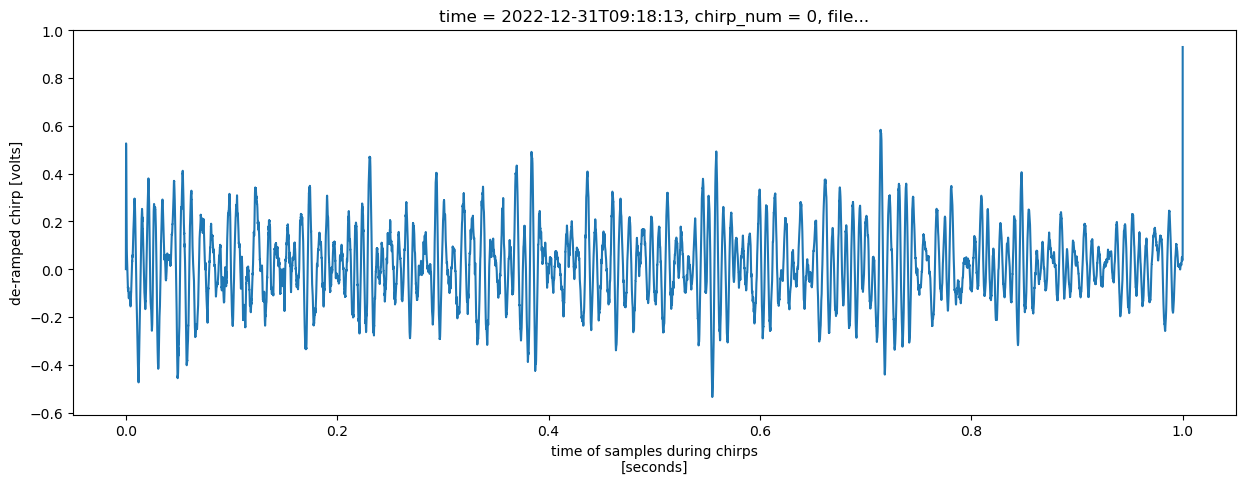

In [156]:
chirp.isel(chirp_num=0).plot(x = 'chirp_time', figsize = (15, 5));

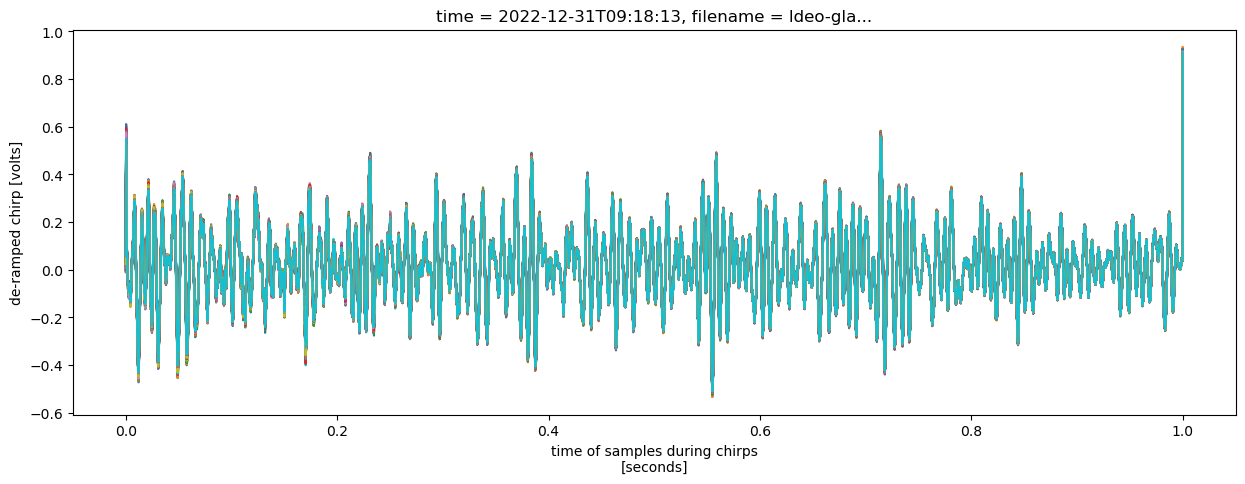

In [157]:
chirp.plot(x = 'chirp_time', hue = 'chirp_num',  add_legend = False, figsize = (15, 5));

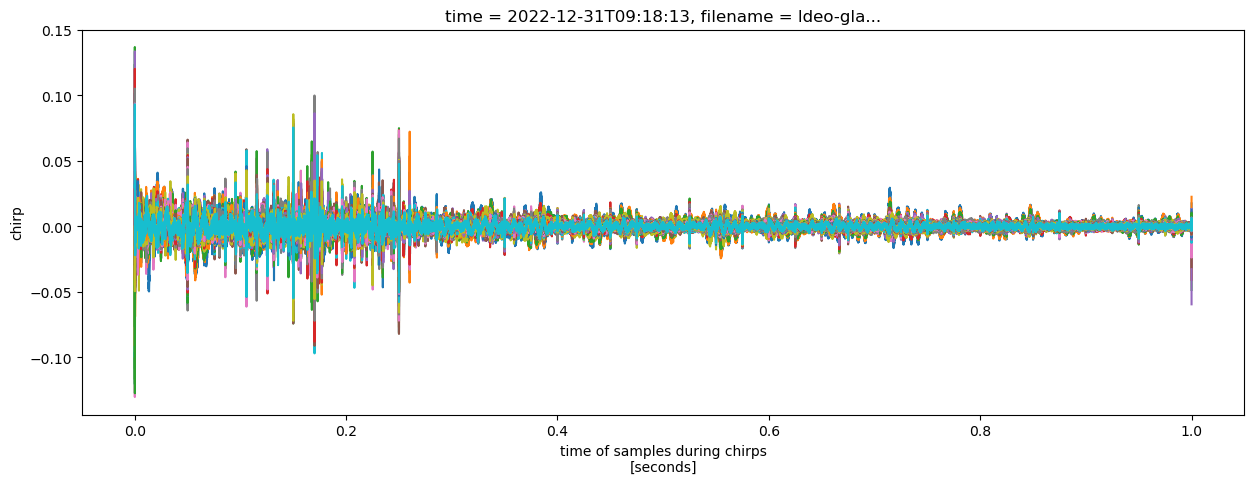

In [158]:
(chirp - chirp.mean(dim='chirp_num')).plot(x = 'chirp_time', hue = 'chirp_num', add_legend = False, figsize = (15, 5));

In [151]:
chirp.nbytes / 1e6

32.0008

In [96]:
s = chirp.isel(chirp_num=0).values.squeeze()
s_stacked = chirp.mean(dim='chirp_num').values.squeeze()

In [85]:
T=1                 # chirp duration
f_1 = 200e6         # starting frequency
f_2 = 400e6         # ending frequency
f_c = (f_1+f_2)/2   # center frequency
B = f_2 - f_1       # bandwidth
sampling_frequency = 40000    # [Hz]
K = B/T             # [Hz/s]
c = 299792458
ep = 3.1

def tau(R):
    return 2*R*np.sqrt(ep)/c
def fft(s):
    no_of_samples = len(s)
    S = np.fft.fft(s)/no_of_samples         
    indexes      = np.arange(no_of_samples) 
    frequencies  = indexes * sampling_frequency/no_of_samples
    return S, frequencies
def range(frequencies):
    return frequencies * c/(2*K*np.sqrt(ep))

(0.0, 3000.0)

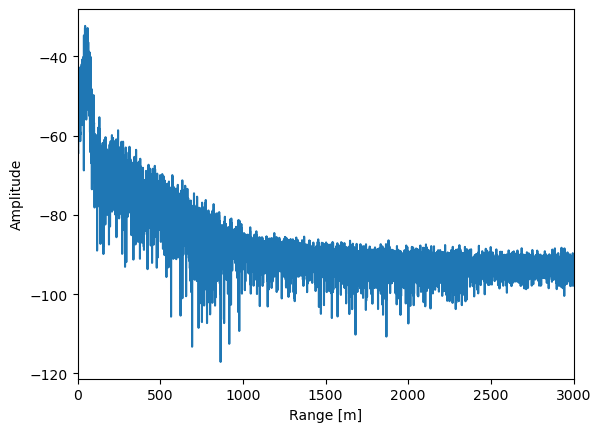

In [98]:
S, frequencies = fft(s)
r = range(frequencies)

plt.plot(r, 20*np.log10(np.abs(S)) )
plt.xlabel('Range [m]')
plt.ylabel('Amplitude')
plt.xlim([0, 3000])

(0.0, 2.0)

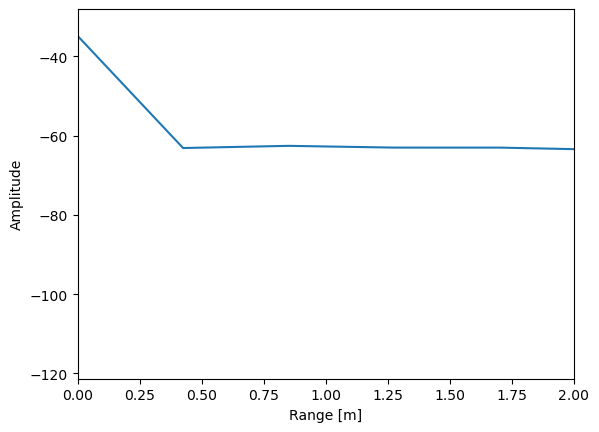

In [102]:
plt.plot(r, 20*np.log10(np.abs(S)) )
plt.xlabel('Range [m]')
plt.ylabel('Amplitude')
plt.xlim([0, 2])

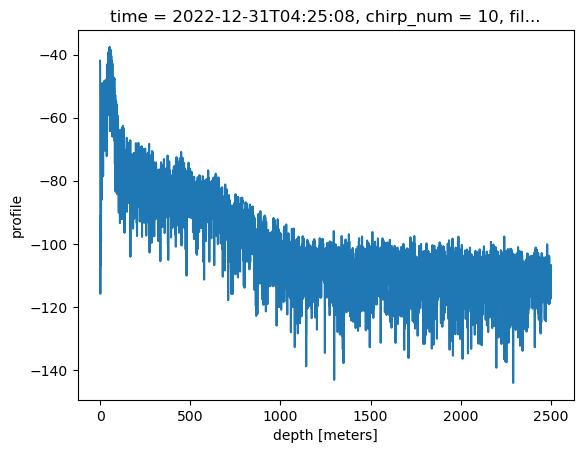

In [65]:
data.profile.isel(chirp_num=10).dB().plot()


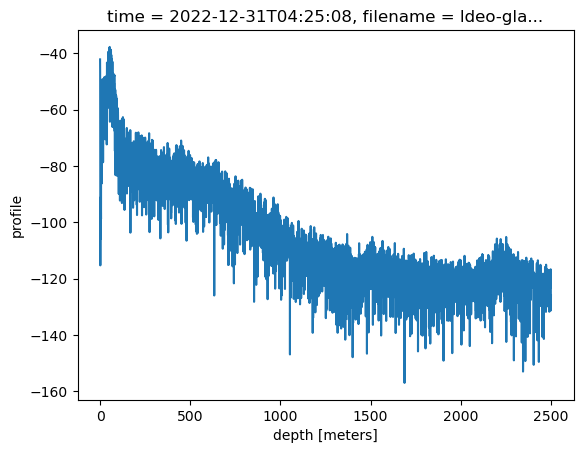

In [66]:
data.profile.mean(dim='chirp_num').dB().plot()


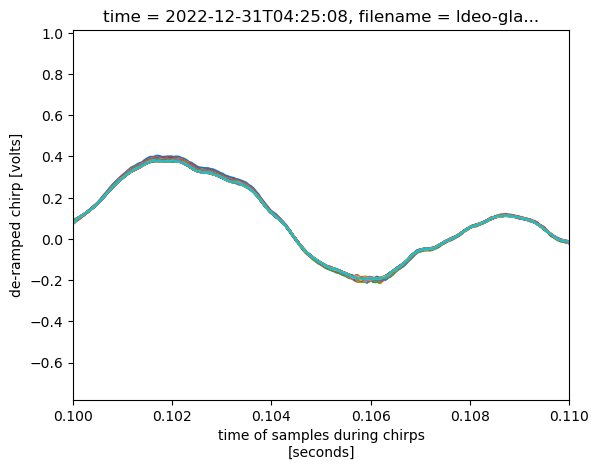

In [67]:
data.chirp.plot(x = 'chirp_time', hue = 'chirp_num', xlim= [0.1,0.11], add_legend = False);

ldeo-glaciology/apres/thwaites/2022-2023/Point/G1-22-05